In [1]:
%matplotlib inline
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

table = Table.read('data/2M19505021+4804508.csv')

In [370]:
from astropy.time import Time

times = Time(table['hjd'], format='jd')
# fluxes = 500 + np.ones(len(times)) + np.random.randn(len(times)) #table['flux (mJy)'].data
# errors = np.ones(len(times)) #5 * table['flux err'].data

fluxes = table['flux (mJy)'].data
errors = table['flux err'].data

#mask = np.ones(len(times)).astype(bool) #(fluxes < 700) & (fluxes > 400)
mask = (fluxes < 700) & (fluxes > 400)

sort = np.argsort(times[mask])

times = times[mask][sort]
fluxes = fluxes[mask][sort]
errors = errors[mask][sort]

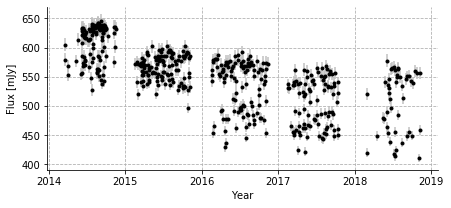

In [371]:
plt.figure(figsize=(7, 3))
plt.errorbar(times.decimalyear, fluxes, errors, fmt='.', color='k', ecolor='silver')
plt.ylabel('Flux [mJy]')
plt.xlabel('Year')
# plt.ylim([400, 700])
ax = plt.gca()

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
    
ax.grid(ls='--')
plt.savefig('plots/asas-sn.pdf', bbox_inches='tight')

In [372]:
# def v_vector(theta):
#     """
#     Hogg+ 2010, Eqn 29.
#     """
#     return [[-np.sin(theta)], [np.cos(theta)]]


# def lnprior(p, max_theta=1.55, min_theta=1.5, min_lnf=0):
#     theta, b, lnf = p
#     if not ((min_theta < theta < max_theta) and (-0.5 < b < 0.5) and
#                 (lnf > min_lnf)):
#         return -np.inf
#     else:
#         return 0


# def ln_likelihood(p, x, y, x_err, y_err):
#     """
#     Hogg+ 2010, Eqn 30., with an additional parameter that scales up the
#     uncertainty in the x dimension, ``x_err``, by a constant factor.

#     The likelihood has been written assuming x and y uncertainties are
#     uncorrelated.
#     """
#     # theta, b, lnf, V = p
#     theta, b, lnf = p

#     # Assert prior:
#     # lnf < min_lnf or V < 0
#     # if (theta < min_theta or theta > max_theta or b < -0.5 or b > 0.5
#     #     or lnf < min_lnf):


#     v = v_vector(theta)
#     f = np.exp(lnf)

#     lnp = lnprior(p)
#     if not np.isfinite(lnp):
#         return lnp

#     delta = v[0][0] * x + v[1][0] * y - b * np.cos(theta)
#     sigma_sq = v[0][0]**2 * (f * x_err)**2 + v[1][0]**2 * y_err**2
#     # sigma_sq = v[0][0]**2 * x_err**2 + v[1][0]**2 * y_err**2
#     ln_like = np.sum(-0.5 * (delta**2 / sigma_sq + np.log(sigma_sq) +
#                      np.log(2*np.pi)))
#     return ln_like

In [391]:
import emcee

def model(p, x): 
    m, b, lnf = p
    return m * x + b

def lnprior(p):
#     m, b, lnf = p
    return 0

def ln_likelihood(p, x, y, y_err):
    m, b, lnf = p
    f = np.exp(lnf)
    return -0.5 * np.sum((model(p, x) - y)**2 / (f * y_err)**2 + np.log(2 * (f * y_err)**2))
    

from multiprocessing import Pool

nwalkers = 10
ndim = 3
n_steps_burnin = 1000
n_steps_postburnin = 10000

p0 = []

while len(p0) < nwalkers: 
    trial = np.array([-30, 500, 1]) + 1 * np.random.randn(ndim)
    if lnprior(trial) == 0:
        p0.append(trial)

args = (times.decimalyear - times.decimalyear.mean(), fluxes, errors)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args=args,
                                    pool=pool)

    # Burn in for this many steps:
    p1 = sampler.run_mcmc(p0, n_steps_burnin)
    sampler.reset()

    p2 = sampler.run_mcmc(p1, n_steps_burnin)
    sampler.reset()

    # Now run for this many more steps:
    sampler.run_mcmc(p2, n_steps_postburnin)

samples = sampler.flatchain #sampler.chain[:, :, :].reshape((-1, ndim))

[array([-29.93311188, 499.17170297,   1.90871778]), array([-3.04545602e+01,  5.01078469e+02, -4.65623193e-02]), array([-2.94045107e+01,  5.00200247e+02,  2.52136674e-01]), array([-2.97924002e+01,  4.99754595e+02, -3.47978854e-01]), array([-28.0266757 , 500.10981633,   1.44729789]), array([-29.7870596 , 501.0384148 ,   1.88836342]), array([-29.08643587, 500.40695726,   1.26958132]), array([-30.51281625, 499.40730969,   0.92477384]), array([-28.91430249, 499.64628983,   0.83520351]), array([-2.78750032e+01,  5.01084990e+02,  7.67620094e-02])]


In [392]:

params, resid, rank, singvals = np.linalg.lstsq(np.vander(times.decimalyear - times.decimalyear.mean(), 2), fluxes)
m_init, b_init = params

print(m_init, b_init)

-27.904126330987303 550.4371257861612


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


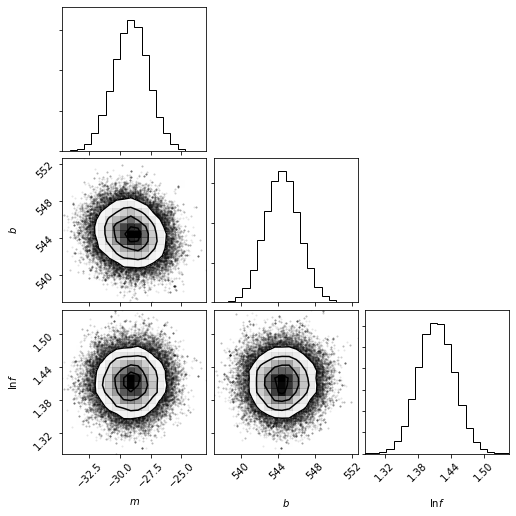

In [393]:
from corner import corner

corner(samples, labels=[r'$m$', '$b$', '$\ln f$'])
plt.show()

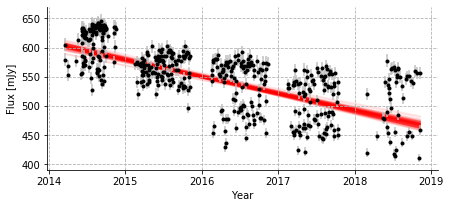

In [399]:
slope = samples[:, 0]
intercept = samples[:, 1]
f = np.exp(samples[:, 2])
# plt.errorbar(times.decimalyear, fluxes, f.mean() * errors, fmt='.', ecolor='silver')
plt.figure(figsize=(7, 3))
plt.errorbar(times.decimalyear, fluxes, errors, fmt='.', color='k', ecolor='silver')
plt.ylabel('Flux [mJy]')
plt.xlabel('Year')
# plt.ylim([400, 700])
ax = plt.gca()

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
    
ax.grid(ls='--')
skip = 1000
for m, b in zip(slope[::skip], intercept[::skip]): 
    plt.plot(times.decimalyear, m*(times.decimalyear - times.decimalyear.mean()) + b, alpha=0.1, color='r', zorder=-10)
# plt.ylim([400, 700])


plt.savefig('plots/asas-sn.pdf', bbox_inches='tight')

In [320]:
from astropy.coordinates import SkyCoord

hat11 = SkyCoord.from_name('HAT-P-11')
c1 = SkyCoord.from_name('GAIA DR2 2086521642419240960')
c2 = SkyCoord.from_name('GAIA DR2 2086521298821848832')

In [36]:
control1 = Table.read('data/64348.csv')   # GAIA DR2 2086521642419240960
control2 = Table.read('data/64655.csv')   # GAIA DR2 2086521298821848832

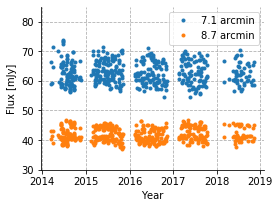

In [54]:
plt.figure(figsize=(4, 3))
plt.plot(Time(control1['hjd'], format='jd').decimalyear, control1['flux (mJy)'], '.',
         label="{0:.1f}".format(c1.separation(hat11).to(u.arcmin)))
plt.plot(Time(control2['hjd'], format='jd').decimalyear, control2['flux (mJy)'], '.', 
         label="{0:.1f}".format(c2.separation(hat11).to(u.arcmin)))
plt.legend()
ax = plt.gca()

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
plt.ylabel('Flux [mJy]')
plt.xlabel('Year')
ax.grid(ls='--')
plt.ylim([30, 85])
plt.savefig('plots/control.pdf', bbox_inches='tight')

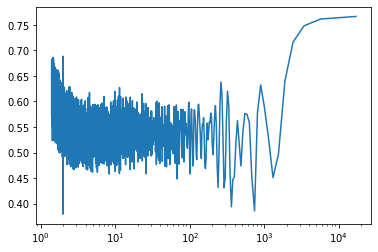

In [28]:
from astropy.timeseries import LombScargle
import astropy.units as u

ls = LombScargle(times, fluxes, errors)

freq, power = ls.autopower()
periods = (1/freq).to(u.day).value

plt.semilogx(periods, power)